In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fusion Classification**

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from imutils import paths
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import shutil
import cv2
import os
import os

In [4]:
def update_files(DIR):
    classes = sorted(os.listdir(DIR))
    classes.remove('BaseballPitch')

    for each_class in classes:
        class_path = os.path.join(DIR, each_class)
        videos = sorted(os.listdir(class_path))

        video_files = []
        for i in range(1, 26):
            if i < 10: padded_num = str(i).zfill(2)
            else: padded_num = str(i)

            video_files.append('v_{}_g{}_c01.avi'.format(each_class, padded_num))

        # Loop through all files in the directory
        for filename in videos:
            if filename not in video_files:
                os.remove(os.path.join(class_path, filename))

    return 'Done'

In [5]:
DIR = '/content/UCF50'
update_files(DIR)

'Done'

In [6]:
dataset_path = os.listdir('/content/UCF50')

label_types = os.listdir('/content/UCF50')
print(label_types)  

['Biking', 'JavelinThrow', 'CleanAndJerk', 'YoYo', 'HighJump', 'WalkingWithDog', 'Skiing', 'Diving', 'Swing', 'SkateBoarding', 'BreastStroke', 'Kayaking', 'BaseballPitch', 'ThrowDiscus', 'PlayingTabla', 'VolleyballSpiking', 'HulaHoop', 'PommelHorse', 'BenchPress', 'SalsaSpin', 'Lunges', 'RockClimbingIndoor', 'PushUps', 'JumpingJack', 'Nunchucks', 'Skijet', 'Billiards', 'PlayingPiano', 'PlayingGuitar', 'JugglingBalls', 'PizzaTossing', 'PoleVault', 'Drumming', 'HorseRace', 'RopeClimbing', 'PlayingViolin', 'SoccerJuggling', 'Fencing', 'PullUps', 'Punch', 'Basketball', 'TennisSwing', 'Rowing', 'JumpRope', 'GolfSwing', 'MilitaryParade', 'TaiChi', 'TrampolineJumping', 'HorseRiding', 'Mixing']


In [7]:
# creating the dataset
data = []

for item in dataset_path:
 class_folder = os.listdir('/content/UCF50/' + item)

 # Add them to the list
 for each_class in class_folder:
   data.append((item, str('/content/UCF50/' + item) + '/' + each_class))
    
# Build a dataframe        
main_df = pd.DataFrame(data=data, columns=['tag', 'video_name'])
print(main_df.shape)

(1325, 2)


In [8]:
main_df.head()

,tag,video_name
0,Biking,/content/UCF50/Biking/v_Biking_g08_c01.avi
1,Biking,/content/UCF50/Biking/v_Biking_g15_c01.avi
2,Biking,/content/UCF50/Biking/v_Biking_g07_c01.avi
3,Biking,/content/UCF50/Biking/v_Biking_g12_c01.avi
4,Biking,/content/UCF50/Biking/v_Biking_g23_c01.avi


In [9]:
train, val = train_test_split(main_df, test_size=0.2, stratify=main_df['tag'])
val, test = train_test_split(val, test_size=0.5, stratify=val['tag'])

print(f"{train.shape}, {test.shape}, {val.shape}")

(1060, 2), (133, 2), (132, 2)


In [10]:
train.to_csv('train.csv')
test.to_csv('test.csv')
val.to_csv('val.csv')

In [12]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
val = pd.read_csv('/content/val.csv')

In [13]:
train.shape

(1060, 3)

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [15]:
IMG_SIZE = 224

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
        
    return np.array(frames)

In [16]:
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [17]:
def build_feature_extractor():
    feature_extractor = MobileNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

9406464/9406464 [==============================] - 1s 0us/step


In [18]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary = np.unique(train["tag"]))
print(label_processor.get_vocabulary())

['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [19]:
labels = train["tag"].values
labels = label_processor(labels[..., None]).numpy()
print(labels)

[[10]
 [37]
 [ 8]
 ...
 [ 0]
 [34]
 [19]]


In [20]:
# Define hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1280

In [21]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :],
                    verbose=0
                )
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train, "train")
val_data, val_labels = prepare_all_videos(val, "val")
test_data, test_labels = prepare_all_videos(test, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

print(f"train_labels in train set: {train_labels.shape}")
print(f"test_labels in train set: {test_labels.shape}")

Frame features in train set: (1060, 20, 1280)
Frame masks in train set: (1060, 20)
train_labels in train set: (1060, 1)
test_labels in train set: (133, 1)


In [22]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

print(f"train_labels in train set: {train_labels.shape}")
print(f"test_labels in train set: {test_labels.shape}")

Frame features in train set: (1060, 20, 1280)
Frame masks in train set: (1060, 20)
train_labels in train set: (1060, 1)
test_labels in train set: (133, 1)


# **Saving the Extracted Feature Data files**

In [24]:
import pickle 

with open('/content/drive/MyDrive/DL_Project/train/train_data.pkl', 'wb') as file:
    pickle.dump(train_data, file)

with open('/content/drive/MyDrive/DL_Project/train/train_labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)

In [25]:
with open('/content/drive/MyDrive/DL_Project/test/test_data.pkl', 'wb') as file:
    pickle.dump(test_data, file)

with open('/content/drive/MyDrive/DL_Project/test/test_labels.pkl', 'wb') as file:
    pickle.dump(test_labels, file)

In [26]:
with open('/content/drive/MyDrive/DL_Project/val/val_data.pkl', 'wb') as file:
    pickle.dump(val_data, file)

with open('/content/drive/MyDrive/DL_Project/val/val_labels.pkl', 'wb') as file:
    pickle.dump(val_labels, file)

# **BiLSTM Model**

In [27]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(frame_features_input, mask=mask_input)
    x = keras.layers.Bidirectional(keras.layers.LSTM(8))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 2000

def run_experiment():
    filepath = "/content/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([val_data[0], val_data[1]], val_labels),
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Validation Accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

history, sequence_model = run_experiment()

Streaming output truncated to the last 5000 lines.
Epoch 751: val_loss did not improve from 2.10606
34/34 [==============================] - 1s 39ms/step - loss: 0.1614 - accuracy: 0.9481 - val_loss: 3.9392 - val_accuracy: 0.6439
Epoch 752/2000
34/34 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9462
Epoch 752: val_loss did not improve from 2.10606
34/34 [==============================] - 2s 56ms/step - loss: 0.1598 - accuracy: 0.9462 - val_loss: 3.9026 - val_accuracy: 0.6288
Epoch 753/2000
33/34 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9413
Epoch 753: val_loss did not improve from 2.10606
34/34 [==============================] - 2s 55ms/step - loss: 0.1725 - accuracy: 0.9415 - val_loss: 4.0612 - val_accuracy: 0.6515
Epoch 754/2000
33/34 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9441
Epoch 754: val_loss did not improve from 2.10606
34/34 [==============================] - 2s 51ms/step - loss: 0.1672 

In [28]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
        frame_mask[i, :length] = 1

    return frame_features, frame_mask

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask], verbose=0)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

Test video path: /content/UCF50/TennisSwing/v_TennisSwing_g12_c01.avi
  TennisSwing: 45.03%
  HighJump: 21.58%
  JavelinThrow: 10.44%
  ThrowDiscus:  7.08%
  PoleVault:  5.59%
  Basketball:  3.65%
  Fencing:  1.09%
  PommelHorse:  1.08%
  Skiing:  0.75%
  HorseRiding:  0.67%
  SkateBoarding:  0.66%
  Diving:  0.57%
  Rowing:  0.53%
  Kayaking:  0.22%
  BreastStroke:  0.20%
  WalkingWithDog:  0.16%
  HorseRace:  0.14%
  TrampolineJumping:  0.14%
  BaseballPitch:  0.13%
  SoccerJuggling:  0.09%
  Skijet:  0.08%
  GolfSwing:  0.03%
  VolleyballSpiking:  0.02%
  JumpRope:  0.02%
  Biking:  0.01%
  Punch:  0.01%
  RopeClimbing:  0.00%
  Nunchucks:  0.00%
  CleanAndJerk:  0.00%
  HulaHoop:  0.00%
  JumpingJack:  0.00%
  MilitaryParade:  0.00%
  Lunges:  0.00%
  PushUps:  0.00%
  TaiChi:  0.00%
  PlayingPiano:  0.00%
  SalsaSpin:  0.00%
  PizzaTossing:  0.00%
  YoYo:  0.00%
  JugglingBalls:  0.00%
  Drumming:  0.00%
  RockClimbingIndoor:  0.00%
  PlayingGuitar:  0.00%
  Swing:  0.00%
  Mixing

In [29]:
sequence_model.evaluate([test_data[0], test_data[1]], test_labels)

5/5 [==============================] - 0s 11ms/step - loss: 2.3267 - accuracy: 0.4511


[2.3267295360565186, 0.451127827167511]

In [30]:
sequence_model.save('MobileNet_plus_BiLSTM.h5')

In [ ]:
history.history['val_accuracy']

In [44]:
def train_val_plot(acc, val_acc, loss, val_loss):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,6))
  fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['Training', 'Validation'])

  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['Training', 'Validation'])

  plt.show()

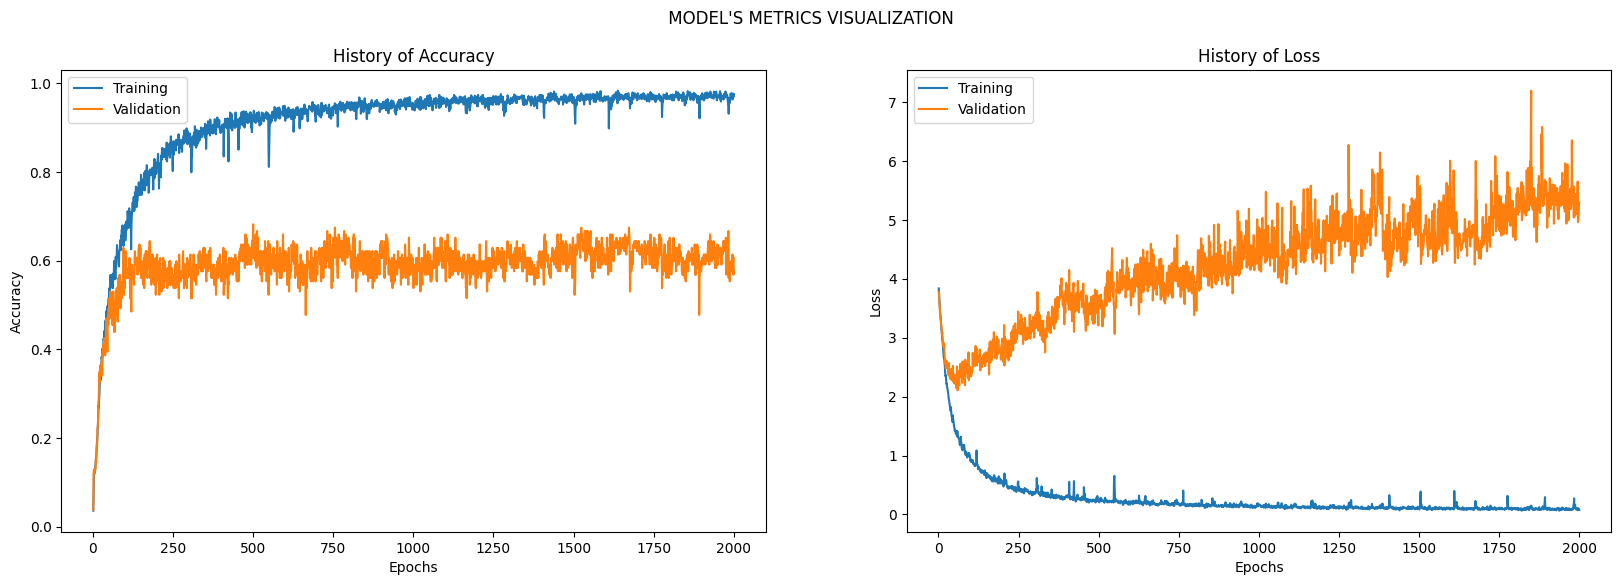

In [45]:
train_val_plot(
    history.history['accuracy'],
    history.history['val_accuracy'],
    history.history['loss'],
    history.history['val_loss']
)